# Intervention Model Classifier

Predict the intervention model from the pubmed abstract of a clinical trial

In [50]:
%store -r abstracts_targets

df = abstracts_targets.ix[:, ['abstract', 'pmid', 'intervention_model']]
df = df[df.intervention_model.notnull()] # filter away abstracts which don't have an associated intervention model

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2085 entries, 0 to 2126
Data columns (total 3 columns):
abstract              2085 non-null object
pmid                  2085 non-null object
intervention_model    2085 non-null object
dtypes: object(3)
memory usage: 65.2+ KB


In [51]:
df.groupby('intervention_model').size()

intervention_model
Crossover Assignment        157
Factorial Assignment         47
Parallel Assignment        1380
Single Group Assignment     501
dtype: int64

### View an Example from Each Class

In [52]:
labels = df.intervention_model.unique()

indexes = [df[df.intervention_model == label].iloc[0].name for label in labels]

for index in indexes:
    pm_url = 'https://www.google.com/search?q=pmid+' + df.iloc[index].pmid + '&btnI=I' # I'm Feeling Lucky
    
    print '*'*5, df.iloc[index].intervention_model, '*'*5
    print df.iloc[index].abstract
    print
    !google-chrome "{pm_url}"
    print

***** Parallel Assignment *****
D-Cycloserine, a partial agonist at the glycine site of the N-methyl-D-aspartate receptor, has demonstrated inconsistent efficacy for negative and cognitive symptoms of schizophrenia. The strongest evidence for efficacy has come from studies using D-cycloserine at a dose of 50 mg/day added to conventional antipsychotics in trials of 8 weeks duration or less. 
                 To assess the efficacy for negative symptoms and cognitive impairment of D-cycloserine augmentation of conventional antipsychotics in a 6-month trial. 
                 Fifty-five schizophrenia patients with prominent negative symptoms, treated with conventional antipsychotics, were randomly assigned to treatment with D-cycloserine 50 mg/day or placebo for 6 months in a double-blind, parallel group design. 
                 Twenty-six subjects completed the 6-month trial; drop-out rates did not differ between treatment groups. D-Cycloserine treatment did not differ from placebo trea

### Word Clouds for Each Class

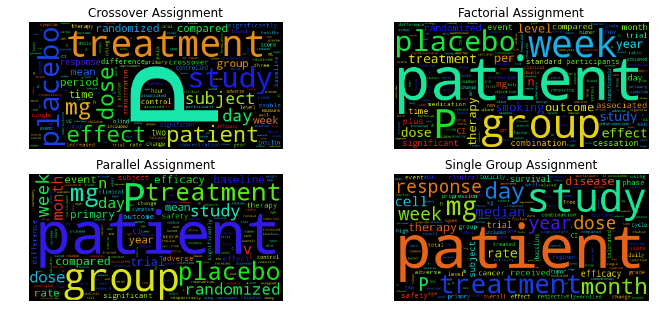

In [53]:
from support import word_cloud

fig = plt.figure(figsize=(12, 5))
plt.clf()

for i, label in enumerate(np.sort(df.intervention_model.unique()), start=1):
    axes = fig.add_subplot(2, 2, i)
    words = ' '.join(df[df.intervention_model == label].abstract)
    
    word_cloud(words, axes, label)
    
plt.axis('off')
plt.show()

### Vectorize Abstracts

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

X = vectorizer.fit_transform(df.abstract)

X.shape

(2085, 214831)

### Extract and Order Vocabulary

In [55]:
import operator

vocabulary = [word for word, index in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]

### Train Test Split

In [56]:
from sklearn.cross_validation import train_test_split

X_train, X_test, ys_train, ys_test = train_test_split(X, df.intervention_model)

X_train.shape, X_test.shape, ys_train.shape, ys_test.shape

((1563, 214831), (522, 214831), (1563,), (522,))

### Hyperparameters

In [57]:
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV

M, N = X_train.shape
K = 3 # number of folds for cross-validation

n_iter = int(np.ceil(10**6/(M-M/K))) # http://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

def search_params(clf, parameters, verbose=3, scoring='f1_macro', k=5):
    """Perform a grid search over the parameters
    
    k: the number of folds to be used for cross-validation
    
    """
    grid_search = GridSearchCV(clf, parameters, verbose=verbose, scoring=scoring, cv=k)
    grid_search.fit(X_train, ys_train)
    
    return grid_search

def plot_hyperparam_performance(grid_search, hyperparam):
    """Takes a grid_search over a hyperparameter and plots it performance"""
    
    # Get scores for different hyperparam settings into dataframe
    df = pd.DataFrame(grid_search.grid_scores_, columns=grid_search.grid_scores_[0]._fields)
    
    # Explode cv scores for each hyperparam setting
    scores = df.cv_validation_scores.apply(pd.Series)
    scores = scores.rename(columns=lambda x: 's{}'.format(x))
    score_columns = scores.columns
    
    scores['f1'], scores['err'] = scores.mean(axis=1), scores.std(axis=1) # mean f1 and stddev for cv scores
    
    # Put hyperparam values into a dataframe
    hyperparams = df.parameters.apply(lambda x: pd.Series(x[hyperparam]))
    hyperparams = hyperparams.rename(columns={0: hyperparam})
    
    df = pd.concat([hyperparams, scores], axis=1) # concatenate the two back together

    # Plot f1 and all the scores for each hyperparam setting
    axes = df['f1'].plot(yerr=df.err, linewidth=.5)
    for s in score_columns:
        axes = df[s].plot(ax=axes, style='.', c='black')
        
    # Fix axes
    axes.set_xticklabels([''] + df[hyperparam].tolist() + [''])
    axes.set_xlim(min(df.index)-1, max(df.index+1))
    axes.set_xlabel(hyperparam)
    axes.set_ylabel('f1')

### Tune `alpha`

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] alpha=1e-06 .....................................................
[CV] ............................ alpha=1e-06, score=0.403823 -   3.7s
[CV] alpha=1e-06 .....................................................
[CV] ............................ alpha=1e-06, score=0.434334 -   3.6s
[CV] alpha=1e-06 .....................................................
[CV] ............................ alpha=1e-06, score=0.394779 -   3.5s
[CV] alpha=1e-05 .....................................................
[CV] ............................ alpha=1e-05, score=0.366834 -   3.6s
[CV] alpha=1e-05 .....................................................
[CV] ............................ alpha=1e-05, score=0.437216 -   3.6s
[CV] alpha=1e-05 .....................................................
[CV] ............................ alpha=1e-05, score=0.386349 -   3.6s
[CV] alpha=0.0001 ....................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.2min finished


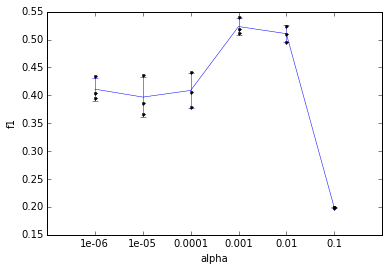

In [58]:
alphas = [{'alpha': 10.0**-np.arange(1,7)[::-1]}]

clf = SGDClassifier(class_weight='auto', n_iter=n_iter)

grid_search = search_params(clf, alphas, k=K)

plot_hyperparam_performance(grid_search, 'alpha')

In [59]:
grid_search.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight='auto', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=959, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [60]:
grid_search.best_score_

0.52329686007272458

### Tune `n_iter`

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.529362 -   0.1s
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.506247 -   0.1s
[CV] n_iter=5 ........................................................
[CV] ............................... n_iter=5, score=0.501061 -   0.0s
[CV] n_iter=10 .......................................................
[CV] .............................. n_iter=10, score=0.538921 -   0.1s
[CV] n_iter=10 .......................................................
[CV] .............................. n_iter=10, score=0.519757 -   0.1s
[CV] n_iter=10 .......................................................
[CV] .............................. n_iter=10, score=0.511305 -   0.1s
[CV] n_iter=100 ......................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.1min finished


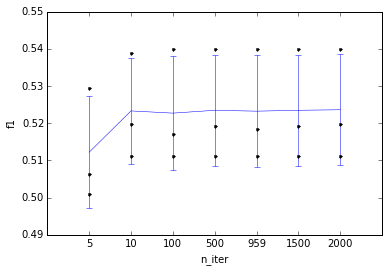

In [64]:
n_iters = [{'n_iter': [5, 10, 100, 500, n_iter, 1500, 2000]}]

clf = SGDClassifier(alpha=.001, class_weight='auto')

grid_search = search_params(clf, n_iters, k=K)

plot_hyperparam_performance(grid_search, 'n_iter')

In [65]:
best_clf = grid_search.best_estimator_

best_clf

SGDClassifier(alpha=0.001, average=False, class_weight='auto', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=2000, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [66]:
grid_search.best_score_

0.52367713661205539

### Prediction on Test Set

In [67]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

import sklearn

predictions = best_clf.predict(X_test)

f1s = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average=None)
f1 = sklearn.metrics.f1_score(lb.fit_transform(ys_test), lb.fit_transform(predictions), average='macro')

import re
from collections import namedtuple

Classes = namedtuple('Classes', map(lambda s: re.sub('\s+', '_', s), best_clf.classes_))

print 'f1s: {}'.format(Classes(*f1s))
print
print 'average: {}'.format(f1)

f1s: Classes(Crossover_Assignment=0.52380952380952384, Factorial_Assignment=0.12121212121212122, Parallel_Assignment=0.83720930232558133, Single_Group_Assignment=0.71966527196652719)

average: 0.550474054828


### Confusion Matrix

#### Observations

- Crossover assignment is often confused as parallel assignment. This makes sense as there are multiple groups, just as in parallel assignment
- Factorial assignment f1 is very low because we just don't have enough data for them. In the word clouds below, you can see *adhd* as being the most strongly correlated unigram with factorial assignments, instead of *combination*, which makes more sense
- Parallel assignment is often classified correctly. The model confuses parallel and single groups

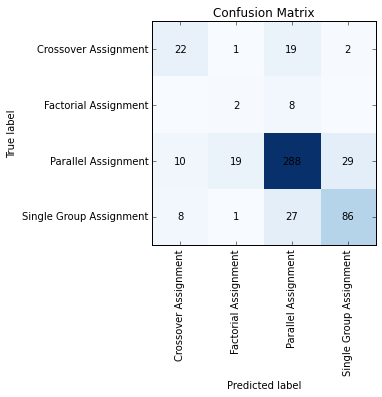

In [68]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

labels = best_clf.classes_

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(labels)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

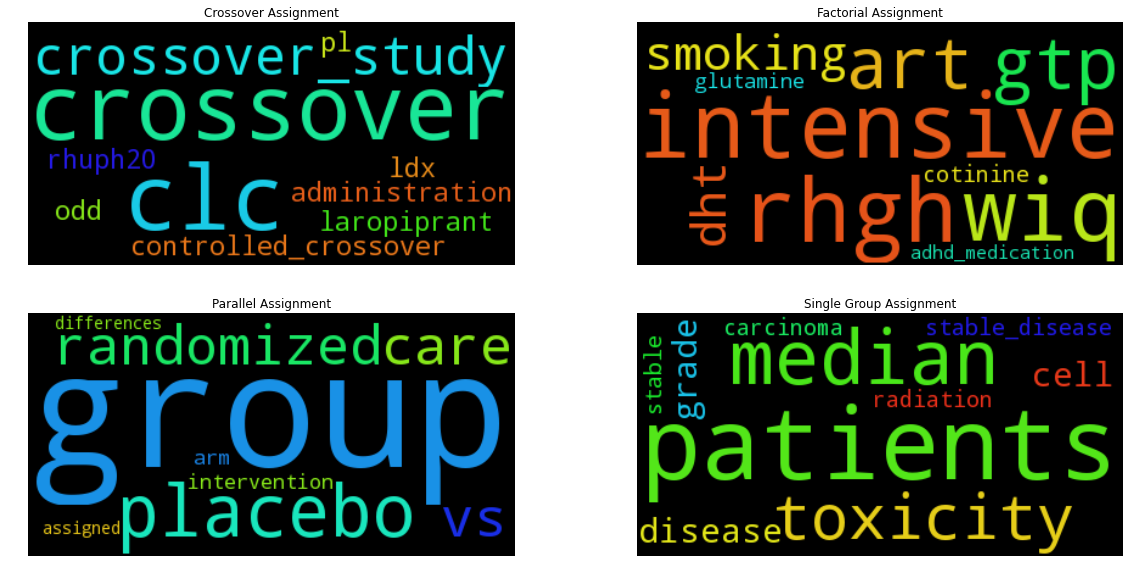

In [69]:
import re

fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(best_clf.coef_, labels), start=1):
    pairs = sorted(zip(weights, vocabulary), reverse=True)[:10]
    pairs = [(pair[0], re.sub('\s+', '_', pair[1])) for pair in pairs]
    
    def duplicate_words(pairs):
        """Yields words duplicated proportional to their corresponding coefficients"""
        
        for coef, word in pairs:
            for _ in range(int(coef*100)):
                yield word
            
    duped_words = list(duplicate_words(pairs))
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(' '.join(duped_words), axes, title)
    
plt.axis('off')
plt.show()